# Extract barrier island metrics along transects

Author: Emily Sturdivant, esturdivant@usgs.gov

***

Extract barrier island metrics along transects for Bayesian Network Deep Dive


## Pre-requisites:
- All the input layers (transects, shoreline, etc.) must be ready. This is performed with the notebook file prepper.ipynb.
- The files servars.py and configmap.py may need to be updated for the current dataset.

## Notes:
- This code contains some in-line quality checking during the processing, which requires the user's attention. For thorough QC'ing, we recommend displaying the layers in ArcGIS, especially to confirm the integrity of values for variables such as distance to inlet (__Dist2Inlet__) and widths of the landmass (__WidthPart__, etc.). 


***

## Import modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import arcpy
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import core.functions_warcpy as fwa
import core.functions as fun

In [1]:
%magic

In [7]:
# %matplotlib inline
%matplotlib --list

Available matplotlib backends: ['qt5', 'ipympl', 'gtk3', 'qt4', 'wx', 'osx', 'notebook', 'agg', 'gtk', 'qt', 'nbagg', 'tk', 'inline']


In [8]:
%notebook foo.ipynb

In [9]:
%profile

UsageError: The `%profile` magic has been deprecated since IPython 2.0. and removed in IPython 6.0. Please use the value of `get_ipython().profile` instead to see current profile in use. Perhaps you meant to use `%prun` to profile code?


In [10]:
%quickref

### Initialize variables

Based on the project directory, and the site and year you input, setvars.py will set a bunch of variables as the names of folders, files, and fields. Set-up the project folder and paths: 

In [2]:
from core.setvars import *

site (options: Parramore, FireIsland, CoastGuard, Assateague, Assawoman, Cobb, RhodeIsland, Smith, ParkerRiver, Monomoy, CapeLookout, Rockaway, Fisherman, Cedar, Forsythe): FireIsland
year (options: 2010, 2012, 2014): 2014
Path to project directory (e.g. \\Macolume\dir\FireIsland2014): ········
setvars.py initialized variables.
SITE: FireIsland
MHW: 0.46
MLW: -1.01
Max dune crest height: 2.5
Projection code: 26918



In [3]:
orig_trans = os.path.join(home, 'origTrans')
extendedTrans = os.path.join(home, 'FireIsland2014_extTrans_null')
extTrans_tidy = os.path.join(home, 'FireIsland_tidyTrans')

inletLines = os.path.join(home, 'FireIsland2014_inletLines')
ShorelinePts = os.path.join(home, 'FireIsland2014_SLpts')
dlPts = os.path.join(home, 'FireIsland2014_DLpts')
dhPts = os.path.join(home, 'FireIsland2014_DHpts')
armorLines = os.path.join(home, 'FireIsland2014_armorLines')
# elevGrid = os.path.join(home, 'FireIsland2014_DEM')
elevGrid_5m = os.path.join(home, 'FireIsland2014_DEM_5m')

# Full island shoreline: polygon that outlines the island shoreline, MHW on oceanside and MTL on bayside
barrierBoundary = os.path.join(home, 'FireIsland2014_bndpoly_2sl')  

SubType = os.path.join(home, 'FI15_SubType')
VegType = os.path.join(home, 'FI15_VegType')
VegDens = os.path.join(home, 'FI15_VegDen')
GeoSet = os.path.join(home, 'FI15_GeoSet')
DisMOSH = os.path.join(home, 'FI15_DisMOSH')

# Temporary values
transPts_null = '{}{}_transPts_null'.format(site, year)
extTrans_null = '{}{}_extTrans_null'.format(site, year)

tr_w_anthro = "fiis14_trans_wBen3fields"

### Convert morphology CSV to point feature classes

In [4]:
datapre = '14CNT02'
csvpath = os.path.join(proj_dir, 'Input_Data', '{}_morphology'.format(datapre), '{}_morphology.csv'.format(datapre))

# state = sitevals['state']
dt_fc, dc_fc, sl_fc = fwa.MorphologyCSV_to_FCsByFeature(csvpath, state, proj_code, csv_fill = 999, 
                                                        fc_fill = -99999, csv_epsg=4326)

... converting dataframe to array... 
... converting array to feature class... 

The projection of m14CNT02_morphology_s16_DT_wgs was changed. The new file is m14CNT02_morphology_s16_DT.
... converting dataframe to array... 
... converting array to feature class... 

The projection of m14CNT02_morphology_s16_DC_wgs was changed. The new file is m14CNT02_morphology_s16_DC.
... converting dataframe to array... 
... converting array to feature class... 

The projection of m14CNT02_morphology_s16_SL_wgs was changed. The new file is m14CNT02_morphology_s16_SL.


## Transect-averaged values
We work with the shapefile/feature class as a Pandas Dataframe as much as possible to speed processing and minimize reliance on the ArcGIS GUI display.

1. Create a pandas dataframe from the transects feature class. In the process, we remove some of the unnecessary fields. The resulting dataframe is indexed by __sort_ID__ with columns corresponding to the attribute fields in the transects feature class. 

In [43]:
# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)
trans_df['DD_ID'] = trans_df.index + sitevals['id_init_val']

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()

Converting feature class to array...
Converting array to dataframe...


In [91]:
# Join LRR values from origTrans to trans_df based on TRANSECTID
origtrans_df = fwa.FCtoDF(orig_trans, id_fld='TRANSECTID', dffields=['TRANSECTID', 'LRR', 'AZIMUTH'])
trans_df = fun.join_columns(trans_df, origtrans_df, id_fld='TRANSECTID') 
trans_df.loc[[1,2,31,32], ['TRANSECTID', 'LRR']]

...converting feature class to array...
...converting array to dataframe...


,TRANSECTID,LRR
sort_ID,,
1,NaN,NaN
2,NaN,NaN
31,3852,1.93
32,3853,1.99


In [71]:
trans_df['DD_ID'] = trans_df.index + sitevals['id_init_val']

In [72]:
# Get anthro fields and join to DF
if 'tr_w_anthro' in locals():
    trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Developmen', 'Nourishmen','Construction'])
    trans_df = fun.join_columns(trans_df, trdf_anthro) 
    
trans_df.sample(5)
trans_df.rename(columns={'Developmen':'Development','Nourishmen':'Nourishment'}, inplace=True)

...converting feature class to array...
...converting array to dataframe...


In [22]:
trans_df.columns

Index(['AZIMUTH', 'Arm_Lat', 'Arm_Lon', 'Arm_zMHW', 'CP_x', 'CP_y', 'CP_zMHW',
       'DH_Lat', 'DH_Lon', 'DH_zMHW', 'DL_Lat', 'DL_Lon', 'DL_zMHW', 'LRR',
       'MLW_x', 'MLW_y', 'SL_Lat', 'SL_Lon', 'TRANSECTID', 'TRANSORDER',
       'bh_mhw', 'bh_mlw', 'bw_mhw', 'bw_mlw', 'SL_x', 'SL_y', 'Bslope',
       'DH_x', 'DH_y', 'DH_z', 'DH_snapX', 'DH_snapY', 'DL_x', 'DL_y', 'DL_z',
       'DL_snapX', 'DL_snapY', 'Arm_x', 'Arm_y', 'Arm_z', 'DH_zmhw', 'DL_zmhw',
       'Arm_zmhw', 'DistDL', 'DistDH', 'DistArm', 'uBW', 'uBH', 'ub_feat',
       'Dist2Inlet', 'WidthFull', 'WidthLand', 'WidthPart', 'DD_ID',
       'Construction', 'Development', 'Nourishment', 'mean_Zmhw', 'max_Zmhw'],
      dtype='object')

### Add XY and Z/slope from DH, DL, SL points within 25 m of transects
Add to each transect row the positions of the nearest pre-created beach geomorphic features (shoreline, dune toe, and dune crest).

Output files for validation:
- pts2trans_SL
- ptSnap2trans_DL
- ptSnap2trans_DH
- arm2trans


#### Shoreline

The MHW shoreline easting and northing (__SL_x__, __SL_y__) are the coordinates of the intersection of the oceanside shoreline with the transect. Each transect is assigned the foreshore slope (__Bslope__) from the nearest shoreline point within 25 m. These values are populated for each transect as follows: 
1. get __SL_x__ and __SL_y__ at the point where the transect crosses the oceanside shoreline; 
2. find the closest shoreline point to the intersection point; 
3. copy the slope value from the shoreline point to the transect in the field __Bslope__.

In [ ]:
# Get the XY position where transect crosses the oceanside shoreline
sl2trans_df = fwa.add_shorelinePts2Trans(extendedTrans, ShorelinePts, shoreline, 
                                         tID_fld, proximity=pt2trans_disttolerance)

# Save as pickle
sl2trans_df.to_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))

# Convert dataframe to feature class
fwa.DFtoFC(sl2trans_df, os.path.join(arcpy.env.scratchGDB, 'pts2trans_SL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["SL_x", "SL_y"], keep_fields=['Bslope'])

#### Dune positions along transects

__DL_x__, __DL_y__, and __DL_zMHW__ are the easting, northing, and height above MHW, respectively, of the nearest dune toe point within 25 meters of the transect. __DH_x__, __DH_y__, and __DH_zMHW__ are the easting, northing, and height above MHW, respectively, of the nearest dune crest point within 25 meters. 

Get the XYZ positions of the nearest dune crest and dune toe within 25 meters of each transect with the following process for each transect: 

1. Find the nearest dune crest/toe point to the transect and proceed if the distance is less than 25 m. 
2. Get the Z value from the point and the XY position 'snapped' to the transect. The 'snapped' XY position is calculated using the arcpy geometry method, which produces a position along the transect nearest to the identified point, i.e. orthogonal to the point. If there are no points within 25 m of the transect, populate the row with a Null value; 
3. Convert the elevations to the MHW datum by applying the MHW offset.

In [5]:
# Dune crest - Create dataframe, Save, Convert to a feature class
dh2trans_df = fwa.find_ClosestPt2Trans_snap(extendedTrans, dhPts, trans_df, 'DH', 
                                            tID_fld, proximity=pt2trans_disttolerance)
dh2trans_df.to_pickle(os.path.join(scratch_dir, 'dh2trans.pkl'))
fwa.DFtoFC(dh2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DH'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["DH_snapX", "DH_snapY"], keep_fields=['DH_z'])

# Dune toe - Create dataframe, Save, Convert to a feature class
dl2trans_df = fwa.find_ClosestPt2Trans_snap(extendedTrans, dlPts, trans_df, 'DL', 
                                            tID_fld, proximity=pt2trans_disttolerance)
dl2trans_df.to_pickle(os.path.join(scratch_dir, 'dl2trans.pkl'))
fwa.DFtoFC(dl2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["DL_snapX", "DL_snapY"], keep_fields=['DL_z'])


Joining shoreline points to transects...
...duration at transect 100: 0:0:21.8 seconds
Duration: 0:0:41.5 seconds

Joining DH points to transects:
Getting name of Z field...
Looking for field _z
Looping through transects to find nearest point within 25 meters...
Duration at transect 100: 0:0:14.5 seconds
Duration: 0:0:26.4 seconds

Joining DL points to transects:
Getting name of Z field...
Looking for field _z
Looping through transects to find nearest point within 25 meters...
Duration at transect 100: 0:0:13.4 seconds
Duration: 0:0:24.3 seconds

Armoring file either missing or empty so we will proceed without armoring data. If shorefront tampering is present at this site, cancel the operations to digitize.


,Azimuth,LCI90,LR2,LRR,LSE,TransOrder,TransectId,SL_x,SL_y,Bslope,...,DH_snapX,DH_snapY,DL_x,DL_y,DL_z,DL_snapX,DL_snapY,Arm_x,Arm_y,Arm_z
sort_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413851.177269,4.107531e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413809.698456,4.107514e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413778.475432,4.107478e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413746.021688,4.107456e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413702.743869,4.107442e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Armoring
__Arm_x__, __Arm_y__, and __Arm_zMHW__ are the easting, northing, and height above MHW, respectively, where an artificial structure crosses the transect in the vicinity of the beach. These features are meant to supplement the dune toe data set by providing an upper limit to the beach in areas where dune toe extraction was confounded by the presence of an artificial structure. Values are populated for each transect as follows: 

1. Get the positions of intersection between the digitized armoring lines and the transects (Intersect tool from the Overlay toolset); 
2. Extract the elevation value at each intersection point from the DEM (Extract Multi Values to Points tool from Spatial Analyst); 
4. Convert the elevations to the MHW datum by applying the MHW offset.

In [ ]:
# Armoring line
arm2trans_df = fwa.ArmorLineToTrans_PD(extendedTrans, armorLines, sl2trans_df, tID_fld, proj_code, elevGrid_5m)

# Save
arm2trans_df.to_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))

### Add all the positions to the trans_df
Join the new dataframes to the transect dataframe. Before it performs the join, `join_columns_id_check()` checks the index and the ID field for potential errors such as whether they are the equal and whether there are duplicated IDs or null values in either.

In [ ]:
# Join positions of shoreline, dune crest, dune toe, armoring
trans_df = fun.join_columns_id_check(trans_df, sl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dh2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, arm2trans_df, tID_fld)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))
# trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

# Display
trans_df.sample(10)

In [3]:
# trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

### Calculate upper beach width and height
Upper beach width (__uBW__) and upper beach height (__uBH__) are calculated based on the difference in position between two points: the position of MHW along the transect (__SL_x__, __SL_y__) and the dune toe position or equivalent (usually __DL_x__, __DL_y__).  In some cases, the dune toe is not appropriate to designate the "top of beach" so beach width and height are calculated from either the position of the dune toe, the dune crest, or the base of an armoring structure. The dune crest was only considered a possibility if the dune crest elevation (__DH_zMHW__) was less than or equal to `maxDH`. 

They are calculated as follows: 
1. Find the position along the transect of an orthogonal line drawn to the dune point (__DL_x__, __DL_y__ and __DH_x__, __DH_y__)
2. Calculate distances from MHW to the position along the transect of the dune toe (__DistDL__), dune crest (__DistDH__), and armoring (__DistArm__). 
3. Conditionally select the appropriate feature to represent "top of beach." Dune toe is prioritized. If it is not available and __DH_zMHW__ is less than or equal to maxDH, use dune crest. If neither of the dune positions satisfy the conditions and an armoring feature intersects with the transect, use the armoring position. If none of the three are possible, __uBW__ and __uBH__ will be null. 
4. Copy the distance to shoreline and height above MHW (__Dist--__, __---zMHW__) to __uBW__ and __uBH__, respectively. 

In [4]:
#%% Calculate distances from shore to dunes, etc.
trans_df, dl2trans, dh2trans, arm2trans = fwa.calc_BeachWidth_fill(extendedTrans, trans_df, maxDH, tID_fld, MHW, fill)

#### Spot-check the beach width values.

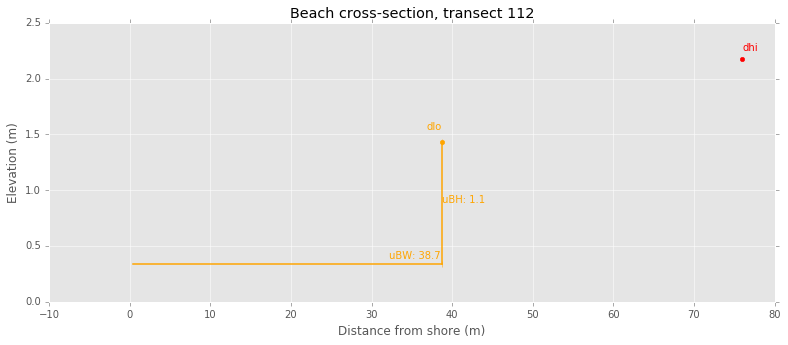

In [71]:
# View distribution of uBW values as descriptive stats and histogram.
fld = 'uBW'
print(pts_df[fld].describe())
pts_df[fld].hist()
plt.show()
plt.close('all')

# Randomly sample 5 rows
ran_samp = trans_df.sample(5)
ran_samp.loc[:,['SL_x', 'SL_y', 'DistDL', 'DL_zmhw', 'DistDH', 'DH_zmhw', 'DistArm', 'Arm_zmhw', 'uBW', 'uBH']]

# # For one row, plot the dlo, dhi position with uBW and uBH
# tran = ran_samp.iloc[0]

# # Beach detail
# fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
# ax = fig.add_subplot(111)

# # Subplot Labels
# ax.set_xlabel('Distance from shore (m)', fontsize = 12)
# ax.set_ylabel('Elevation (m)', fontsize = 12)
# ax.set_title('Beach cross-section, transect {}'.format(tran.name))

# # Beach points
# plt.scatter(tran.DistDL, tran.DL_z, color='orange')
# plt.annotate('dlo', xy=(tran.DistDL-tran.DistDL*0.05, tran.DL_z+tran.DL_z*0.08), color='orange')
# plt.scatter(tran.DistDH, tran.DH_z, color='red')
# plt.annotate('dhi', xy=(tran.DistDH-0.02, tran.DH_z+0.08), color='red')
# plt.scatter(tran.DistArm, tran.Arm_z, color='black')
# plt.annotate('armor', xy=(tran.DistArm-20, tran.Arm_z+0.5), color='black')

# # Upper beach width and height
# uBW = tran.uBW
# uBH = tran.uBH
# plt.plot([MHW, uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
# plt.annotate('uBW: {:.1f}'.format(uBW), xy=(uBW*0.83, MHW+0.05), color='orange')
# plt.plot([uBW, uBW],[MHW, MHW + uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')
# plt.annotate('uBH: {:.1f}'.format(uBH), xy=(uBW+0.03, MHW+uBH*0.5), color='orange')

# plt.show()
# plt.close('all')

### Dist2Inlet


Distance to nearest tidal inlet (__Dist2Inlet__) was computed as alongshore distance of each sampling transect from the nearest tidal inlet. This distance includes changes in the path of the shoreline rather than just a straight-line distance between each transect and the inlet and reflects sediment transport pathways. 

It was measured using the oceanside shoreline between inlets (ShoreBetweenInlets). Note that the ShoreBetweenInlets feature class must be both dissolved and singlepart so that each feature represents one-and-only-one shoreline that runs the entire distance between two inlets or equivalent. If the shoreline is bounded on both sides by an inlet, measure the distance to both and assign the minimum distance of the two. If the shoreline meets only one inlet (meaning the study area ends before the island ends), use the distance to the only inlet. This uses the cut, disjoint, and length geometry methods and properties in ArcPy data access module.

The function measure_Dist2Inlet() prints a warning when the difference in Dist2Inlet between two consecutive transects is greater than 300. 

In [5]:
# Calc Dist2Inlet in new dataframe 
dist_df = fwa.measure_Dist2Inlet(shoreline, extendedTrans, inletLines, tID_fld)

# Save
dist_df.to_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, dist_df, tID_fld, fill=fill)

Duration: 0:0:2.2 seconds


### Clip transects, get barrier widths
Calculates __WidthLand__, __WidthFull__, and __WidthPart__, which measure different flavors of the cross-shore width of the barrier island. __WidthLand__ is the above-water distance between the back-barrier and seaward MHW shorelines. __WidthLand__ only includes regions of the barrier within the shoreline polygon (bndpoly_2sl) and does not extend into any of the sinuous or intervening back-barrier waterways and islands. __WidthFull__ is the total distance between the back-barrier and seaward MHW shorelines (including space occupied by waterways). __WidthPart__ is the width of only the most seaward portion of land within the shoreline. 

These are calculated as follows: 

1. Clip the transect to the full island shoreline (Clip in the Analysis toolbox); 
2. For __WidthLand__, get the length of the multipart line segment from &quot;SHAPE@LENGTH&quot; feature class attribute. When the feature is multipart, this will include only the remaining portions of the transect; 
3. For __WidthPart__, convert the clipped transect from multipart to singlepart and get the length of the first line segment, which should be the most seaward; 
4. For __WidthFull__, calculate the distance between the first vertex and the last vertex of the clipped transect (Feature Class to NumPy Array with explode to points, pandas groupby, numpy hypot).

Temporary layers (assuming default names):

- clip2island
- clip2islandSingle_temp'

In [12]:
# Clip transects, get barrier widths *SPATIAL*
widths_df = fwa.calc_IslandWidths(extendedTrans, barrierBoundary, tID_fld=tID_fld)

# Save
widths_df.to_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))

Clipping the transects to the barrier island boundaries...
Getting the width along each transect of the oceanside land (WidthPart)...
Converting feature class to array...
Converting array to dataframe...
Getting the width along each transect of the entire barrier (WidthFull)...
Converting feature class vertices to array with X and Y...
Converting array to dataframe...
Getting the width along each transect of above water portion of the barrier (WidthLand)...


In [73]:
for fld in trans_df.columns:
    if fld in ['GeoSet', 'SubType', 'VegDens', 'VegType', 'Construction', 'Development', 'Nourishment', 'ub_feat']:
        print('{} values: {}'.format(fld, '  |  '.join(str(x) for x in trans_df.loc[:,fld].unique())))
    else:
        col = trans_df.loc[:,fld]
        col.replace(fill, np.nan, inplace=True)
        mn = col.min(skipna=True)
        mx = np.max(trans_df.loc[:,fld])
        print('{} min|max: {}  |  {}'.format(fld, mn, mx))

AZIMUTH min|max: 335.43  |  358.75
Arm_Lat min|max: 40.621256122000034  |  40.775292712000066
Arm_Lon min|max: -73.28484986799998  |  -72.71456768099995
Arm_zMHW min|max: 1.6007318878173828  |  7.5082464599609375
CP_x min|max: 642717.822141  |  692950.852077
CP_y min|max: 4498087.80075  |  4516358.33774
CP_zMHW min|max: 1.250064  |  5.916509666442871
DH_Lat min|max: 40.6212386721  |  40.7759089676
DH_Lon min|max: -73.3125087537  |  -72.7131091218
DH_zMHW min|max: 1.314658  |  9.980597999999999
DL_Lat min|max: 40.6211758135  |  40.7757518808
DL_Lon min|max: -73.3125794784  |  -72.7130277285
DL_zMHW min|max: 1.250064  |  4.971914
LCI90 min|max: 0.14  |  5.62
LR2 min|max: 0.0  |  0.93
LRR min|max: -2.37  |  12.01
LSE min|max: 13.89  |  192.76
MLW_x min|max: 642748.3067739861  |  692985.3783487115
MLW_y min|max: 4497845.539386016  |  4516308.67100101
SL_Lat min|max: 40.62056464700004  |  40.77522307700008
SL_Lon min|max: -73.31566884099993  |  -72.71327152399994
TRANSECTID min|max: 1189.0 

In [92]:
# Save
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))

## 5-m Points
The point dataset samples the land every 5 m along each shore-normal transect. 

### Split transects into points at 5-m intervals. 

It is created from the tidied transects (tidyTrans, created during pre-processing) as follows: 

1. Clip the tidied transects (tidyTrans) to the shoreline polygon (bndpoly_2sl) , retaining only those portions of the transects that represent land.
2. Produce a dataframe of point positions along each transect every 5 m starting from the ocean-side shoreline. This uses the positionAlongLine geometry method accessed witha Search Cursor and saves the outputs in a new dataframe. 
3. Create a point feature class from the dataframe. 

Temporary files: 
- tran5mPts_unsorted

In [29]:
pts_df, pts_presort = fwa.TransectsToPointsDF(extTrans_tidy, barrierBoundary, fc_out=pts_presort)
print("OUTPUT: '{}' in scratch geodatabase.".format(os.path.basename(pts_presort)))

# Save
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_presort.pkl'))

Clipping transects to within the shoreline bounds ('tidytrans_clipped')...
Getting points every 5m along each transect and saving in new dataframe...
Converting dataframe to feature class ('transPts_unsorted')...
... converting dataframe to array... 
... converting array to feature class... 

Duration: 0:5:41.1 seconds
OUTPUT: 'transPts_unsorted' in scratch geodatabase.


### Add Elevation and Slope to points

__ptZmhw__ and __ptSlp__ are the elevation and slope at the 5-m cell corresponding to the point. 
1. Create the slope and DEM rasters if they don't already exist. We use the 5-m DEM to generate a slope surface (Slope tool in 3D Analyst). 
2. Use Extract Multi Values to Points tool in Spatial Analyst. 
3. Convert the feature class back to a dataframe

In [32]:
# Create slope raster from DEM
if not arcpy.Exists(slopeGrid):
    arcpy.Slope_3d(elevGrid_5m, slopeGrid, 'PERCENT_RISE')
    print("OUTPUT: slope file in designated home geodatabase.")
    
# Add elevation and slope values at points.
arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[elevGrid_5m, 'ptZ'], [slopeGrid, 'ptSlp']])
print("OUTPUT: added slope and elevation to '{}' in designated scratch geodatabase.".format(os.path.basename(pts_presort)))

# Save
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_extractedZ_presort.pkl'))

OUTPUT: slope file in designated home geodatabase.
OUTPUT: added slope and elevation to 'transPts_unsorted' in designated scratch geodatabase.


In [38]:
if 'SubType' in locals():
    # Add substrate type, geomorphic setting, veg type, veg density values at points.
    arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[SubType, 'SubType'], [VegType, 'VegType'], 
                                                           [VegDens, 'VegDens'], [GeoSet, 'GeoSet'],
                                                            [DisMOSH, 'DisMOSH']])

    # Convert to dataframe
    pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp', 'SubType', 
                                                             'VegType', 'VegDens', 'GeoSet','DisMOSH'])
    # Recode fill values
    pts_df.replace({'GeoSet': {9999:np.nan}, 'SubType': {9999:np.nan}, 'VegType': {9999:np.nan},
                    'VegDens': {9999:np.nan}, 'DisMOSH': {99999:np.nan}}, inplace=True)
else:
    print("Plover BN layers not specified (we only check for SubType), so we'll proceed without them. ")
    # Convert to dataframe
    pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp'])

# Save and view sample
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
pts_df.sample(5)

,DisMOSH,GeoSet,SHAPE@X,SHAPE@Y,SubType,VegDens,VegType,ptSlp,ptZ,sort_ID
6319,61.213203,2.0,690290.3825,4.515364e+06,7777.0,666.0,77.0,1.775485,2.660383,1038.0
48198,NaN,5.0,663313.4290,4.503387e+06,6666.0,555.0,55.0,4.793307,1.421202,446.0
700,NaN,NaN,691142.2039,4.516468e+06,NaN,NaN,NaN,2.056738,0.043691,1062.0
2626,NaN,5.0,690887.2127,4.515757e+06,NaN,888.0,99.0,7.237897,0.831639,1052.0
66921,11665.472656,2.0,654922.1504,4.500572e+06,7777.0,666.0,77.0,1.823994,1.906677,269.0


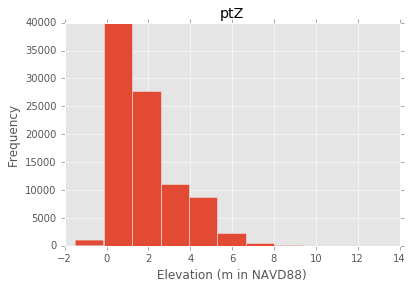

In [41]:
# Print histogram of elevation extracted to points
plots = pts_df.hist('ptZ')

# Subplot Labels
plots[0][0].set_xlabel("Elevation (m in NAVD88)")
plots[0][0].set_ylabel("Frequency")

# Display
plt.show()
plt.close()

### Calculate distances and sort points

__SplitSort__ is a unique numeric identifier of the 5-m points at the study site, sorted by order along shoreline and by distance from oceanside. __SplitSort__ values are populated by sorting the points by __sort_ID__ and __Dist_Seg__ (see below). 

__Dist_Seg__ is the Euclidean distance between the point and the seaward shoreline (__SL_x__, __SL_y__). __Dist_MHWbay__ is the distance between the point and the bayside shoreline and is calculated by subtracting the __Dist_Seg__ value from the __WidthPart__ value of the transect. 

__DistSegDH__, __DistSegDL__, and __DistSegArm__ measure the distance of each 5-m point from the dune crest and dune toe position along a particular transect. They are calculated as the Euclidean distance between the 5-m point and the given feature. 

In [48]:
# Load saved dataframes
pts_df = pd.read_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))

In [49]:
sorted_pt_flds = ['SplitSort', 'seg_x', 'seg_y',
    'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm',
    'ptZ', 'ptSlp', 'ptZmhw',
    'GeoSet', 'SubType', 'VegDens', 'VegType',
    'sort_ID','TRANSORDER', 'TRANSECTID', 'DD_ID', 'AZIMUTH',
    'LRR', 'SL_x', 'SL_y', 'Bslope',
    'DL_x', 'DL_y', 'DL_z', 'DL_zmhw', 'DL_snapX','DL_snapY',
    'DH_x', 'DH_y', 'DH_z', 'DH_zmhw', 'DH_snapX','DH_snapY',
    'Arm_x', 'Arm_y', 'Arm_z', 'Arm_zmhw',
    'DistDH', 'DistDL', 'DistArm',
    'Dist2Inlet', 'WidthPart', 'WidthLand', 'WidthFull',
    'uBW', 'uBH', 'ub_feat', 'mean_Zmhw', 'max_Zmhw',
    'Construction', 'Development', 'Nourishment']

In [93]:
# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, and sort points (SplitSort)
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, sitevals['MHW'], fill)

# Aggregate ptZmhw to max and mean and join to transects
pts_df, zmhw = fun.aggregate_z(pts_df, sitevals['MHW'], tID_fld, 'ptZ', fill)
trans_df = fun.join_columns(trans_df, zmhw) 

# Join transect values to pts
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# pID_fld needs to be among the columns
if not pID_fld in pts_df.columns:
    pts_df.reset_index(drop=False, inplace=True)

# Drop extra fields and sort columns
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore')
pts_df = pts_df.reindex_axis(sorted_pt_flds, axis=1)

# Save dataframes 
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

# View random rows from the points DF
pts_df.sample(5)

SplitSort already existed in dataframe, but it was replaced.


,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
52735,52735,673164.3400,4.508303e+06,415.000004,24.123015,322.694886,346.097180,NaN,0.430632,1.158677,...,439.123019,439.123019,65.489711,2.056664,DL,0.806340,3.040355,111.0,111.0,222.0
49378,49378,671393.1695,4.507247e+06,280.000001,145.417542,224.528158,240.729111,NaN,0.438330,0.343556,...,425.417543,425.417543,39.188285,4.487887,DL,1.134199,8.076544,111.0,111.0,222.0
5807,5807,644923.0746,4.498107e+06,35.000029,459.350292,-24.635573,-15.886525,NaN,2.319790,1.550247,...,494.350320,494.350320,50.772899,2.848550,DL,1.887595,5.266784,111.0,222.0,222.0
68812,68812,681095.6526,4.511759e+06,175.000006,76.218036,96.591903,135.154197,NaN,4.692642,0.553278,...,251.218041,251.218041,37.394590,2.112632,DL,2.992178,5.574584,111.0,333.0,222.0
85979,85979,691113.6993,4.515729e+06,94.999992,495.901642,34.349207,59.345617,56.00368,3.666029,6.288123,...,1129.490528,1230.922659,35.619589,2.487300,DL,1.742307,7.388047,222.0,111.0,222.0


### Recode the values for CSV output and model running

In [94]:
# Recode
pts_df4csv = pts_df.replace({'SubType': {7777:'{1111, 2222}', 1000:'{1111, 3333}'}, 
                              'VegType': {77:'{11, 22}', 88:'{22, 33}', 99:'{33, 44}'},
                              'VegDens': {666: '{111, 222}', 777: '{222, 333}', 
                                          888: '{333, 444}', 999: '{222, 333, 444}'}})

# Fill NAs
pts_df4csv.fillna(fill, inplace=True) 

# Save and view sample
pts_df4csv.to_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df4csv.sample(5)

,SplitSort,seg_x,seg_y,Dist_Seg,Dist_MHWbay,DistSegDH,DistSegDL,DistSegArm,ptZ,ptSlp,...,WidthLand,WidthFull,uBW,uBH,ub_feat,mean_Zmhw,max_Zmhw,Construction,Development,Nourishment
22692,22692,653198.0204,4.500054e+06,90.000020,233.291264,9.114223,25.134356,27.375402,4.604404,6.016068,...,323.291283,323.291283,64.627065,2.676699,DL,1.325224,4.401430,222.0,333.0,222.0
61211,61211,676388.7797,4.510149e+06,590.240446,-286.499760,567.008678,573.096575,-99999.000000,0.290489,0.219511,...,638.631995,713.872411,16.657145,1.868806,DL,0.192224,4.023687,111.0,111.0,222.0
4649,4649,644315.7122,4.498438e+06,394.999982,150.206640,322.203657,330.942680,-99999.000000,2.073167,2.314414,...,545.206622,545.206622,63.994803,2.950734,DL,1.738689,4.790738,111.0,111.0,222.0
34195,34195,659372.4163,4.502250e+06,330.000009,91.357735,259.368251,265.608810,-99999.000000,1.081043,22.664707,...,421.357744,421.357744,64.233928,3.521911,DL,1.574440,5.160199,111.0,111.0,222.0
45604,45604,669540.3128,4.506129e+06,165.000019,218.603645,99.064651,110.308745,-99999.000000,1.085462,6.575984,...,383.603664,383.603664,54.582421,2.209768,DL,1.105386,3.636230,111.0,111.0,222.0


In [96]:
pts_sample = pts_df4csv.loc[:, ['sort_ID', 'TRANSECTID', 'AZIMUTH', 'LRR']].sample(10)
pts_sample

,sort_ID,TRANSECTID,AZIMUTH,LRR
57697,712.0,1672.0,335.43,-0.41
44173,559.0,1519.0,335.43,0.69
9434,102.0,3923.0,358.75,-0.67
61102,740.0,1700.0,335.43,-0.54
41656,496.0,1456.0,335.43,0.62
21403,222.0,4043.0,342.93,-0.75
22952,237.0,1197.0,342.21,-0.60
28093,297.0,1257.0,342.21,-0.11
72158,901.0,1861.0,335.43,-0.94
21960,225.0,4046.0,342.93,-0.75


In [97]:
pts_df4csv.loc[:10, ['SplitSort', 'sort_ID', 'TRANSECTID', 'AZIMUTH', 'LRR']]

,SplitSort,sort_ID,TRANSECTID,AZIMUTH,LRR
0,0,1.0,-99999.0,-99999.0,-99999.0
1,1,2.0,-99999.0,-99999.0,-99999.0
2,2,3.0,-99999.0,-99999.0,-99999.0
3,3,4.0,-99999.0,-99999.0,-99999.0
4,4,5.0,-99999.0,-99999.0,-99999.0
5,5,6.0,-99999.0,-99999.0,-99999.0
6,6,7.0,-99999.0,-99999.0,-99999.0
7,7,8.0,-99999.0,-99999.0,-99999.0
8,8,8.0,-99999.0,-99999.0,-99999.0
9,9,8.0,-99999.0,-99999.0,-99999.0


## Quality checking
Look at extracted profiles from around the island. Entered the transect ID within the available range when prompted. Evaluated the plots for consistency among variables. Repeat various times until you can be satisfied that the variables are consistent with each other and appear to represent reality.

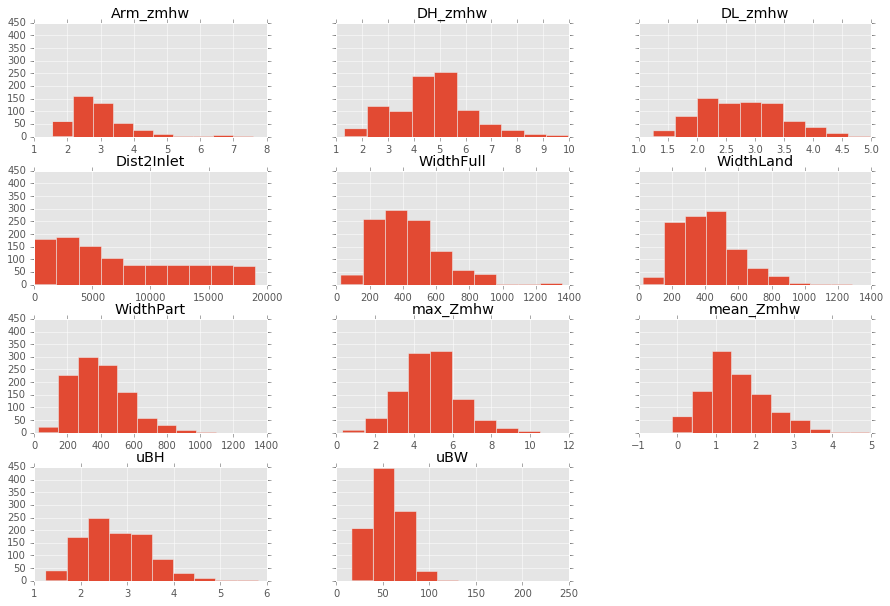

In [56]:
desccols = ['DL_zmhw', 'DH_zmhw', 'Arm_zmhw', 'uBW', 'uBH', 'Dist2Inlet', 
            'WidthPart', 'WidthLand', 'WidthFull', 'mean_Zmhw', 'max_Zmhw']
trans_df.loc[:,desccols].describe()
trans_df.hist(desccols, sharey=True, figsize=[15, 10])
plt.show()
plt.close('all')

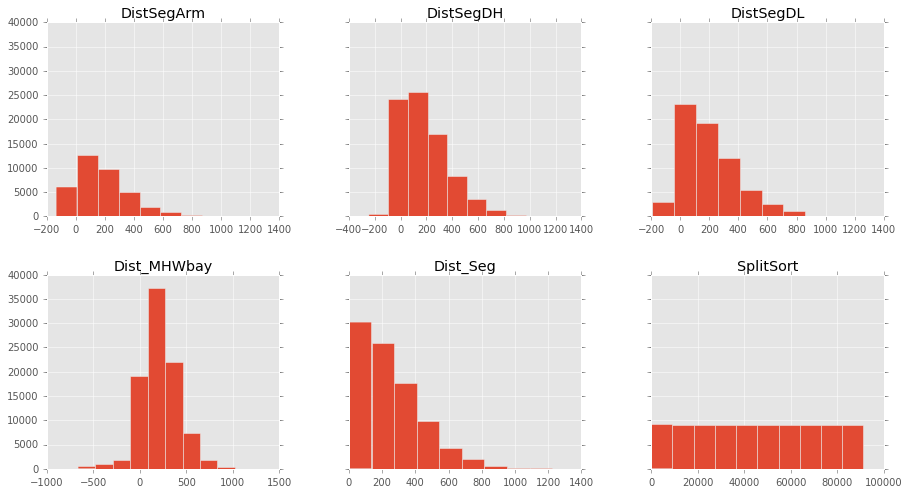

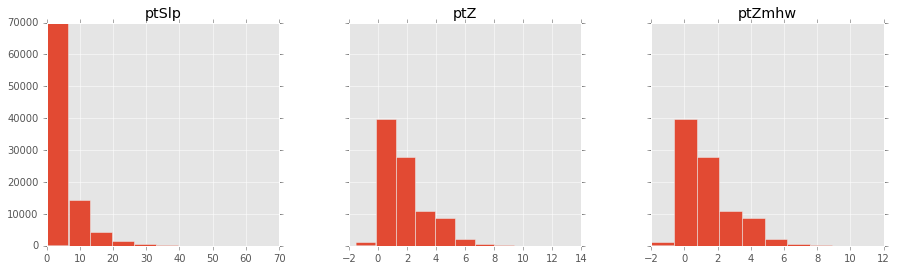

In [57]:
flds_dist = ['SplitSort', 'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm']
flds_z = ['ptZmhw', 'ptZ', 'ptSlp']
pts_df.loc[:,flds_dist+flds_z].describe()
pts_df.hist(flds_dist, sharey=True, figsize=[15, 8], layout=(2,3))
pts_df.hist(flds_z, sharey=True, figsize=[15, 4], layout=(1,3))
plt.show()
plt.close('all')

Transect ID ("sort_ID" 1-1102): 900


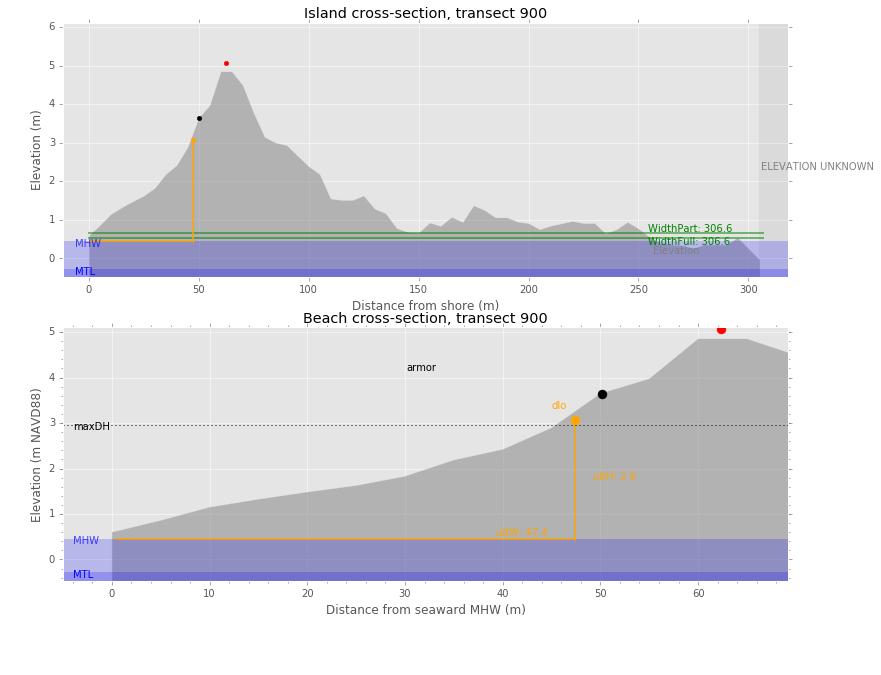

In [61]:
# Prompt for transect identifier (sort_ID) and get all points from that transect.
trans_in = int(input('Transect ID ("sort_ID" {:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Plot
fig = plt.figure(figsize=(13,10))

# Plot the width of the island.
ax1 = fig.add_subplot(211)
try:
    fun.plot_island_profile(ax1, pts_set, sitevals['MHW'], sitevals['MTL'])
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass

# Zoom in on the upper beach.
ax2 = fig.add_subplot(212)
try:
    fun.plot_beach_profile(ax2, pts_set, sitevals['MHW'], sitevals['MTL'], maxDH)
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass 

# Display
plt.show()
plt.close('all')

## Outputs

### Transect-averaged
Output the transect-averaged metrics in the following formats:
- transects, unpopulated except for ID values, as gdb feature class
- transects, unpopulated except for ID values, as shapefile
- populated transects with fill values as gdb feature class
- populated transects with null values as gdb feature class
- populated transects with fill values as shapefile
- raster of beach width (__uBW__) by transect

In [ ]:
# Load the dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))

#### Vector format

In [108]:
# # Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
# trans_fc = fwa.JoinDFtoFC(trans_df, extendedTrans, tID_fld, out_fc=extTrans_fill)

# # Create transect FC with null values
# fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=extTrans_null, out_dir=home)

# # Save final transect SHP with fill values
# out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, extTrans_shp+'.shp')
# print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

# Create transect file with only ID values and geometry to publish.
trans_flds = ['TRANSECTID', 'TRANSORDER', 'DD_ID']
trans_4pub = fwa.JoinDFtoFC(trans_df.loc[:,trans_flds], extendedTrans, tID_fld, out_fc=sitevals['code']+'_trans')
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_4pub, scratch_dir, sitevals['code']+'_trans.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created fiis_trans from input dataframe and FireIsland2014_extTrans_null file.
OUTPUT: fiis_trans.shp in specified scratch_dir.


In [109]:
# Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
trans_fc = fwa.JoinDFtoFC(trans_df, extendedTrans, tID_fld, out_fc=trans_name+'_fill')

# Create transect FC with null values
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=trans_name+'_null', out_dir=home)

# Save final transect SHP with fill values
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, trans_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created fiis14_trans_fill from input dataframe and FireIsland2014_extTrans_null file.
OUTPUT: fiis14_trans_null
OUTPUT: fiis14_trans_shp.shp in specified scratch_dir.


#### Raster - beach width

In [102]:
# Create a template raster corresponding to the transects. 
if not arcpy.Exists(rst_transID):
    print("{} was not found so we will create the base raster.".format(os.path.basename(rst_transID)))
    outEucAll = arcpy.sa.EucAllocation(extTrans_tidy, maximum_distance=50, cell_size=cell_size, source_field=tID_fld)
    outEucAll.save(os.path.basename(rst_transID))

# Create raster of uBW values by joining trans_df to the template raster.
out_rst = fwa.JoinDFtoRaster(trans_df, os.path.basename(rst_transID), bw_rst, fill, tID_fld, 'uBW')

OUTPUT: fiis14_ubw. Field "Value" is ID and "uBW" is beachwidth.


### 5-m points
#### Tabular format
Save final pts with fill values as CSV

In [98]:
# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, pts_name +'.csv')
pts_df4csv.to_csv(csv_fname, na_rep=fill, index=False)
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(csv_fname)))

OUTPUT: fiis14_pts.csv in specified scratch_dir.


#### Vector format

In [99]:
# Convert pts_df to FC - automatically converts NaNs to fills (default fill is -99999)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, pts_name+'_fill'), 
                          spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])

# Save final FCs with null values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=pts_name+'_null', out_dir=home)

# Save final points as SHP with fill values
out_pts_shp = arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, pts_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_pts_shp))))

Converting points DF to FC...
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: fiis14_pts_fill
Duration: 0:9:29.6 seconds
OUTPUT: fiis14_pts_null
OUTPUT: fiis14_pts_shp.shp in specified scratch_dir.


In [100]:
print('{}{} -- Number of points in dataset: {}'.format(site, year, pts_df4csv.shape))
for fld in pts_df4csv.columns:
    if fld in ['GeoSet', 'SubType', 'VegDens', 'VegType', 'Construction', 'Development', 'Nourishment', 'ub_feat']:
        print('{} values: {}'.format(fld, '  |  '.join(str(x) for x in pts_df4csv.loc[:,fld].unique())))
    else:
        col = pts_df4csv.loc[:,fld]
        col.replace(fill, np.nan, inplace=True)
        mn = col.min(skipna=True)
        mx = np.max(pts_df4csv.loc[:,fld])
        print('{} min|max: {}  |  {}'.format(fld, mn, mx))

FireIsland2014 -- Number of points in dataset: (91285, 55)
SplitSort min|max: 0  |  91284
seg_x min|max: 642452.5053000003  |  693300.5998
seg_y min|max: 4498010.0582  |  4516968.503900001
Dist_Seg min|max: 0.0  |  1359.559068327002
Dist_MHWbay min|max: -662.8796383833827  |  1210.5718634452955
DistSegDH min|max: -245.72220068679144  |  1270.6643468930165
DistSegDL min|max: -189.5707552132664  |  1308.1615868720996
DistSegArm min|max: -135.31299454743362  |  1300.7735586442
ptZ min|max: -1.5  |  12.099376678466797
ptSlp min|max: 0.0  |  66.01898956298828
ptZmhw min|max: -1.9600000381469727  |  11.639376640319824
GeoSet values: -99999.0  |  1.0  |  2.0  |  3.0  |  4.0  |  5.0  |  6.0
SubType values: -99999  |  4444.0  |  {1111, 2222}  |  6666.0  |  3333.0
VegDens values: -99999  |  111.0  |  {111, 222}  |  {333, 444}  |  555.0
VegType values: -99999  |  11.0  |  {11, 22}  |  {22, 33}  |  {33, 44}  |  55.0
sort_ID min|max: 1.0  |  1102.0
TRANSORDER min|max: 990.0  |  2057.0
TRANSECTID mi